In [20]:
import torch
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, \
AlbertForSequenceClassification, XLNetForSequenceClassification, CamembertForSequenceClassification, \
FlaubertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, \
BertTokenizer, RobertaTokenizer, AlbertTokenizer, XLNetTokenizer, CamembertTokenizer, FlaubertTokenizer
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from torch.autograd import Variable
import random
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
  
lemmatizer = WordNetLemmatizer()

In [6]:
def tokenize_and_pad(transformer_model, sentences):
    """ We are using .encode_plus. This does not make specialized attn masks 
        like in our selectional preferences experiment. Revert to .encode if
        necessary."""
    
    input_ids = []
    segment_ids = [] # token type ids
    attention_masks = []
    
    if transformer_model.split("-")[0] == 'bert':
        tok = BertTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'roberta':
        tok = RobertaTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'albert':
        tok = AlbertTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'xlnet':
        tok = XLNetTokenizer.from_pretrained(transformer_model)
    elif 'camembert' in transformer_model:
        tok = CamembertTokenizer.from_pretrained(transformer_model)
    elif 'flaubert' in transformer_model:
        tok = FlaubertTokenizer.from_pretrained(transformer_model)

    for sent in sentences:
        sentence = sent[0]

        # encode_plus is a prebuilt function that will make input_ids, 
        # add padding/truncate, add special tokens, + make attention masks 
        encoded_dict = tok.encode_plus(
                        sentence,                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,      # Pad & truncate all sentences.
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True, # Construct attn. masks.
                        # return_tensors = 'pt',     # Return pytorch tensors.
                   )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # Add segment ids, add 1 for verb idx
        segment_id = encoded_dict['token_type_ids']
        segment_id[sent[2]] = 1
        segment_ids.append(segment_id)

        attention_masks.append(encoded_dict['attention_mask'])

    return input_ids, attention_masks, segment_ids


def decode_result(transformer_model, encoded_sequence):

    if transformer_model.split("-")[0] == 'bert':
        tok = BertTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'roberta':
        tok = RobertaTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'albert':
        tok = AlbertTokenizer.from_pretrained(transformer_model)
    elif transformer_model.split("-")[0] == 'xlnet':
        tok = XLNetTokenizer.from_pretrained(transformer_model)
    elif 'camembert' in transformer_model:
        tok = CamembertTokenizer.from_pretrained(transformer_model)
    elif 'flaubert' in transformer_model:
        tok = FlaubertTokenizer.from_pretrained(transformer_model)
    
    # decode + remove special tokens
    tokens_to_remove = ['[PAD]', '<pad>', '<s>', '</s>']
    decoded_sequence = [w.replace('Ġ', '').replace('▁', '').replace('</w>', '')
                        for w in list(tok.convert_ids_to_tokens(encoded_sequence))
                        if not w.strip() in tokens_to_remove]
    
    return decoded_sequence

In [127]:
# load finetuned model

tokenizer_model = 'albert-base-v2'
verb_segment_ids = 'no'
model_save_path = 'checkpoints/friedrich_captions_data/telicity/'

if tokenizer_model.split("-")[0] == 'bert':
    model = BertForSequenceClassification.from_pretrained(model_save_path + tokenizer_model + '_' + verb_segment_ids)
elif tokenizer_model.split("-")[0] == 'roberta':
    model = RobertaForSequenceClassification.from_pretrained(model_save_path + tokenizer_model + '_' + verb_segment_ids)
elif tokenizer_model.split("-")[0] == 'albert':
    model = AlbertForSequenceClassification.from_pretrained(model_save_path + tokenizer_model + '_' + verb_segment_ids)
elif tokenizer_model.split("-")[0] == 'xlnet':
    model = XLNetForSequenceClassification.from_pretrained(model_save_path + tokenizer_model + '_' + verb_segment_ids)
elif 'camembert' in tokenizer_model:
    model = CamembertForSequenceClassification.from_pretrained(model_save_path + tokenizer_model + '_' + verb_segment_ids)
elif 'flaubert' in tokenizer_model:
    model = FlaubertForSequenceClassification.from_pretrained(model_save_path + tokenizer_model + '_' + verb_segment_ids)

In [128]:
# open unseen test set

test_sentences = {}
test_labels = {}
    
with open('data/unseen_tests/ukwac_telic_sents.tsv', 'r', encoding='utf-8') as f:
    for line in f:
        l = line.strip().split('\t')
        verb = lemmatizer.lemmatize(l[-3], pos='v')
        if verb == 'cutted':
            verb = 'cut'
        elif verb == 'fell':
            verb = 'fall'
        if not verb in test_sentences:
            test_sentences[verb] = []
            test_labels[verb] = []
        test_sentences[verb].append([l[1], l[-3], int(l[-2])])
        test_labels[verb].append(0)

with open('data/unseen_tests/ukwac_atelic_sents.tsv', 'r', encoding='utf-8') as f:
    for line in f:
        l = line.strip().split('\t')
        verb = lemmatizer.lemmatize(l[-3], pos='v')
        if verb == 'felt':
            verb = 'feel'
        elif verb == 'sitted':
            verb = 'sit'
        elif verb == 'saw':
            verb = 'see'
        if not verb in test_sentences:
            test_sentences[verb] = []
            test_labels[verb] = []
        test_sentences[verb].append([l[1], l[-3], int(l[-2])])
        test_labels[verb].append(1)

In [129]:
# for verb in test_sentences:
#     print(verb, '\t', len(test_sentences[verb]), '\t', ('telic' if test_labels[verb][0] == 0 else 'atelic'))

In [130]:
verb = 'stay'

use_segment_ids = False
test_inputs, test_masks, test_segments = tokenize_and_pad(tokenizer_model, test_sentences[verb][:100])

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels[verb][:100])
test_masks = torch.tensor(test_masks)
test_segments = torch.tensor(test_segments)

In [131]:
# Return attentions for each sentence of the test set, attentions per sentence (not batched per layer)

model.eval()

all_inputs = []
sent_attentions = []
sentences = []
predicted_labels = []
prob_prediction = []

for inputs in test_inputs:
    
    test_input = inputs.resize(1, 128)
    
    with torch.no_grad():        
        outputs = model(test_input, 
                        token_type_ids=None, 
                        attention_mask=None)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    attentions = outputs[1]
    
    log_probs = F.softmax(Variable(torch.from_numpy(logits)), dim=-1)

    predicted_labels += np.argmax(logits, axis=1).flatten().tolist()
    prob_prediction += log_probs.tolist()
    
    sentence = decode_result(tokenizer_model, inputs)
    sentences.append(sentence)
    len_sequence = len(sentence)
    
    temp_attentions = [] # turn attention to (layer, head, size, size)
    
    for layer in attentions:
        temp = torch.squeeze(layer) #remove dimension of batch size = 1
        temp = np.array(temp)[:, :len_sequence, :len_sequence]
        temp_attentions.append(temp)
        
    sent_attentions.append(np.asarray(temp_attentions))

avg telic: 0.32642980813980105
avg atelic: 0.6735702002048493


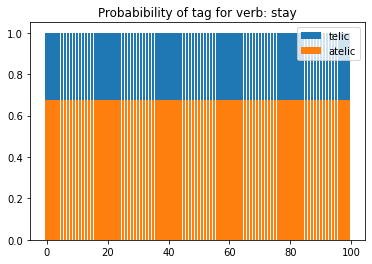

In [132]:
# visualize results

all_telic_probs = [x[0] for x in prob_prediction]
all_atelic_probs = [x[1] for x in prob_prediction]

print('avg telic:', sum(all_telic_probs)/len(all_telic_probs))
print('avg atelic:', sum(all_atelic_probs)/len(all_atelic_probs))

plt.title('Probabibility of tag for verb: ' + verb)

plt.bar(list(range(len(all_telic_probs))), [1 for n in all_telic_probs])
plt.bar(list(range(len(all_atelic_probs))), sorted(all_atelic_probs))
plt.legend(['telic', 'atelic'])
# plt.plot(list(range(len(all_telic_probs))), sorted(all_telic_probs))
# plt.plot(list(range(len(all_atelic_probs))), sorted(all_atelic_probs))